In [59]:
#carregando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from yellowbrick.cluster import KElbowVisualizer

In [2]:
#carrega dados de mercado
df_market = pd.read_csv('../data/estaticos_market.csv')

In [3]:
df_aux = pd.DataFrame(data={
    'colunas':df_market.columns,
    'missing':df_market.isna().sum(),
    'qtd':df_market.shape[0]
})
df_aux['tx_miss'] = round(df_aux['missing']/df_aux['qtd'],2)
df_market = df_market.drop(list(df_aux.query(f'tx_miss >= {0.995}').colunas),axis=1)

In [4]:
#carrega portfólio
df_portfolio = pd.read_csv('../data/estaticos_portfolio1.csv')

In [5]:
#coloca id como índice
df_market = df_market.set_index('id')

In [42]:
#selecte boolean features
def select_by_variance(df,threshold,var_type):
    sel_bool = VarianceThreshold(threshold=threshold)
    fitted_model = sel.fit(df.select_dtypes(include=var_type))
    features = df.select_dtypes(include=var_type).columns[fitted_model.get_support()]
    return features

def preprocessing(df,col_group,nan_resolve):
    info_empresa = ['de_indicador_telefone',
    'de_nivel_atividade',
    'de_ramo',
    'fl_email',
    'fl_mei',
    'fl_telefone',
    'idade_empresa_anos',
    'natureza_juridica_macro',
    'nm_divisao',
    'qt_filiais',
    'sg_uf']
    print('--Criando dataframe com as colunas--')
    df_empresa = df[col_group]

    print('--Aplicando OneHotEnconding--')
    df_encoded = pd.get_dummies(df_empresa)

    if nan_resolve == 'median':
        df_encoded = df_encoded.fillna(df_encoded.median())
        #df_encoded
        #df_encoded = df_encoded.reset_index()
        #imputer = SimpleImputer(missing_values='NaN',strategy='median')
        #for col in df_encoded.select_dtypes(include=['float','int']).columns:
            #median = imputer.fit_transform(df_encoded[[col]]).ravel()
            #df_encoded[col] = median
    else:
        pass

    print('--Aplicando MinMaxScaler--')
    minmax = StandardScaler()
    minmax_transformed = minmax.fit_transform(df_encoded)
    df_encoded_std = pd.DataFrame(data=minmax_transformed,columns=df_encoded.columns)

    print('--split features target--')
    target = df[['de_ramo']]
    print(df_encoded_std.median())
    features = df_encoded_std
    #print(features.isna().sum())
    print('--Aplicando Árvore--')
    decision_tree = ExtraTreesClassifier(n_jobs=-1,n_estimators=20)
    model_fited = decision_tree.fit(features,target)
    print('--Selecionando Modelo--')
    model = SelectFromModel(model_fited,prefit=True)
    col_features = df_encoded_std.columns[model.get_support()]
    df_return = df_encoded_std[col_features]
    return df_return

#função para recomendar leads
def recommender(df_test,df_market,modelo):
    distance, index = modelo.kneighbors(df_test)
    distance = distance.flatten()
    index = index.flatten()
    recomendados = df_market.iloc[index]
    recomendados['distance'] = distance
    recomendados = recomendados.sort_values(by=['distance'],ascending=True)
    return recomendados['id']

def get_metrics(ids_true, ids_pred):
    tp = len(set(ids_true) & set(ids_pred))
    fp = ids_pred.shape[0] - tp
    fn = ids_true.shape[0] - tp
    tn = df_train.shape[0] - ids_pred.shape[0]
    p = ids_true.shape[0]
    n = df_train.shape[0] - p
    accuracy = (tp)/p
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print(f'Total de Recomendações Corretas: {len(set(ids_true) & set(ids_pred))}')
    return (accuracy,precision,recall)

## Teste de seleção de features colocando o ramo da empresa como variável alvo

## Qualificação das variáveis
1. As variáveis foram agrupadas em 7 grupos
2. As features serão avaliadas isoladamente dentro de cada grupo
3. Após esta análise ser escolhida uma variável categórica para ser o target
4. Será feita uma seleção de feature utilizando RandomForest. Será utilizado o inverso do índice de Gini como peso para cada variável

In [7]:
#convertendo variaveis object para bool
convert_to_bool = [
'fl_optante_simei',
'fl_optante_simples',
'fl_passivel_iss',
'fl_rm',
'fl_sa',
'fl_simples_irregular',
'fl_spa',
'fl_st_especial',
'fl_telefone',
'fl_veiculo'
]
for col in convert_to_bool:
    df_market[col] = df_market[col].astype(bool)

In [8]:
info_empresa = ['de_indicador_telefone',
'de_nivel_atividade',
'de_ramo',
'fl_email',
'fl_mei',
'fl_telefone',
'idade_empresa_anos',
'natureza_juridica_macro',
'nm_divisao',
'qt_filiais',
'sg_uf']

In [9]:
info_filiais = [
'coligada_mais_antiga_ativa',
'coligada_mais_nova_ativa',
'de_faixa_faturamento_estimado',
'de_faixa_faturamento_estimado_grupo',
'faturamento_est_coligados',
'faturamento_est_coligados_gp',
'idade_maxima_coligadas',
'idade_media_coligadas',
'idade_media_coligadas_ativas',
'idade_minima_coligadas',
'max_faturamento_est_coligados',
'max_faturamento_est_coligados_gp',
'max_filiais_coligados',
'max_funcionarios_coligados_gp',
'max_vl_folha_coligados',
'max_vl_folha_coligados_gp',
'media_faturamento_est_coligados',
'media_faturamento_est_coligados_gp',
'media_filiais_coligados',
'media_funcionarios_coligados_gp',
'media_vl_folha_coligados',
'media_vl_folha_coligados_gp',
'min_faturamento_est_coligados',
'min_faturamento_est_coligados_gp',
'min_filiais_coligados',
'min_funcionarios_coligados_gp',
'min_vl_folha_coligados',
'min_vl_folha_coligados_gp',
'qt_coligadas',
'qt_coligados',
'qt_coligados_agropecuaria',
'qt_coligados_atividade_alto',
'qt_coligados_atividade_baixo',
'qt_coligados_atividade_inativo',
'qt_coligados_atividade_medio',
'qt_coligados_atividade_mt_baixo',
'qt_coligados_ativo',
'qt_coligados_baixada',
'qt_coligados_ccivil',
'qt_coligados_centro',
'qt_coligados_comercio',
'qt_coligados_epp',
'qt_coligados_exterior',
'qt_coligados_inapta',
'qt_coligados_industria',
'qt_coligados_ltda',
'qt_coligados_matriz',
'qt_coligados_me',
'qt_coligados_mei',
'qt_coligados_nordeste',
'qt_coligados_norte',
'qt_coligados_nula',
'qt_coligados_sa',
'qt_coligados_serviço',
'qt_coligados_sudeste',
'qt_coligados_sul',
'qt_coligados_suspensa',
'qt_funcionarios_coligados',
'qt_funcionarios_coligados_gp',
'qt_ramos_coligados',
'qt_regioes_coligados',
'qt_socios_coligados',
'qt_ufs_coligados',
'sum_faturamento_estimado_coligadas',
'total_filiais_coligados',
'vl_faturamento_estimado_aux',
'vl_faturamento_estimado_grupo_aux',
'vl_folha_coligados',
'vl_folha_coligados_gp'
]

In [10]:
info_funcionarios = [
'grau_instrucao_macro_escolaridade_fundamental',
'grau_instrucao_macro_escolaridade_media',
'grau_instrucao_macro_escolaridade_superior',
'idade_acima_de_58',
'idade_ate_18',
'idade_de_19_a_23',
'idade_de_24_a_28',
'idade_de_29_a_33',
'idade_de_34_a_38',
'idade_de_39_a_43',
'idade_de_44_a_48',
'idade_de_49_a_53',
'idade_de_54_a_58',
'max_meses_servicos',
'max_meses_servicos_all',
'media_meses_servicos',
'media_meses_servicos_all',
'meses_ultima_contratacaco',
'min_meses_servicos',
'min_meses_servicos_all',
'percent_func_genero_fem',
'percent_func_genero_masc',
'qt_admitidos',
'qt_admitidos_12meses',
'qt_desligados',
'qt_desligados_12meses',
'qt_ex_funcionarios',
'qt_funcionarios',
'qt_funcionarios_12meses',
'qt_funcionarios_24meses',
'qt_funcionarios_grupo',
'total',
'tx_crescimento_12meses',
'tx_crescimento_24meses',
'tx_rotatividade'
]


In [11]:
info_ibge = [
'empsetorcensitariofaixarendapopulacao',
'nm_micro_regiao'    
]

In [12]:
info_socios = [
'idade_maxima_socios',
'idade_media_socios',
'idade_minima_socios',
'qt_socios',
'qt_socios_feminino',
'qt_socios_masculino',
'qt_socios_pep',
'qt_socios_pf',
'qt_socios_pj',
'qt_socios_pj_ativos',
'qt_socios_pj_baixados',
'qt_socios_pj_inaptos',
'qt_socios_pj_nulos',
'qt_socios_pj_suspensos',
'qt_socios_st_regular',
'qt_socios_st_suspensa',
'vl_idade_maxima_socios_pj',
'vl_idade_media_socios_pj',
'vl_idade_minima_socios_pj',    
]

In [13]:
info_transporte = [
'fl_antt',
'fl_optante_simples',
'fl_spa',
'fl_veiculo',
'qt_art',
'vl_frota',
'vl_potenc_cons_oleo_gas',
'vl_total_veiculos_leves',
'vl_total_veiculos_leves_grupo',
'vl_total_veiculos_pesados',
'vl_total_veiculos_pesados_grupo'    
]

In [14]:
info_tributaria = [
'de_saude_rescencia',
'de_saude_tributaria',
'fl_optante_simei',
'fl_passivel_iss',
'fl_simples_irregular',
'nu_meses_rescencia'
]

In [15]:
df_empresa = preprocessing(df_market,info_empresa,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
fl_email             -0.896797
fl_mei               -0.696124
fl_telefone           0.614873
idade_empresa_anos   -0.337426
qt_filiais           -0.061322
                        ...   
sg_uf_AM             -0.464742
sg_uf_MA             -0.617626
sg_uf_PI             -0.445947
sg_uf_RN             -0.521472
sg_uf_RO             -0.373021
Length: 144, dtype: float64
--Aplicando Árvore--
--Selecionando Modelo--


In [16]:
df_empresa

,de_ramo_BENS DE CONSUMO,de_ramo_COMERCIO E REPARACAO DE VEICULOS,de_ramo_COMERCIO POR ATACADO,de_ramo_COMERCIO VAREJISTA,de_ramo_INDUSTRIA DA CONSTRUCAO,de_ramo_SERVICOS ADMINISTRATIVOS,de_ramo_SERVICOS DE ALOJAMENTO/ALIMENTACAO,de_ramo_SERVICOS DE EDUCACAO,de_ramo_SERVICOS DE SAUDE,de_ramo_SERVICOS DIVERSOS,...,nm_divisao_ALIMENTACAO,nm_divisao_ATIVIDADES DE ATENCAO A SAUDE HUMANA,nm_divisao_ATIVIDADES DE ORGANIZACOES ASSOCIATIVAS,nm_divisao_COMERCIO E REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS,nm_divisao_COMERCIO POR ATACADO EXCETO VEICULOS AUTOMOTORES E MOTOCICLETAS,nm_divisao_COMERCIO VAREJISTA,nm_divisao_CONSTRUCAO DE EDIFICIOS,nm_divisao_EDUCACAO,nm_divisao_SERVICOS ESPECIALIZADOS PARA CONSTRUCAO,nm_divisao_TRANSPORTE TERRESTRE
0,-0.219376,-0.225424,-0.192168,-0.771177,4.150573,-0.219912,-0.264276,-0.158368,-0.147073,-0.387366,...,-0.251685,-0.138767,-0.299197,-0.225424,-0.192168,-0.771177,6.890518,-0.158368,-0.178603,-0.159285
1,-0.219376,-0.225424,-0.192168,-0.771177,-0.240931,-0.219912,3.783917,-0.158368,-0.147073,-0.387366,...,3.973213,-0.138767,-0.299197,-0.225424,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,-0.159285
2,-0.219376,-0.225424,-0.192168,-0.771177,-0.240931,-0.219912,-0.264276,-0.158368,-0.147073,-0.387366,...,-0.251685,-0.138767,-0.299197,-0.225424,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,6.278073
3,-0.219376,-0.225424,-0.192168,-0.771177,-0.240931,-0.219912,-0.264276,-0.158368,-0.147073,2.581539,...,-0.251685,-0.138767,-0.299197,-0.225424,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,-0.159285
4,-0.219376,-0.225424,-0.192168,-0.771177,-0.240931,-0.219912,-0.264276,-0.158368,-0.147073,-0.387366,...,-0.251685,-0.138767,-0.299197,-0.225424,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,-0.159285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462293,-0.219376,4.436093,-0.192168,-0.771177,-0.240931,-0.219912,-0.264276,-0.158368,-0.147073,-0.387366,...,-0.251685,-0.138767,-0.299197,4.436093,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,-0.159285
462294,-0.219376,-0.225424,-0.192168,-0.771177,-0.240931,4.547271,-0.264276,-0.158368,-0.147073,-0.387366,...,-0.251685,-0.138767,-0.299197,-0.225424,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,-0.159285
462295,-0.219376,-0.225424,-0.192168,-0.771177,-0.240931,-0.219912,-0.264276,-0.158368,6.799346,-0.387366,...,-0.251685,7.206306,-0.299197,-0.225424,-0.192168,-0.771177,-0.145127,-0.158368,-0.178603,-0.159285
462296,-0.219376,-0.225424,-0.192168,1.296719,-0.240931,-0.219912,-0.264276,-0.158368,-0.147073,-0.387366,...,-0.251685,-0.138767,-0.299197,-0.225424,-0.192168,1.296719,-0.145127,-0.158368,-0.178603,-0.159285


In [17]:
df_funcionarios = preprocessing(df_market,info_funcionarios,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
grau_instrucao_macro_escolaridade_fundamental   -0.018838
grau_instrucao_macro_escolaridade_media         -0.021175
grau_instrucao_macro_escolaridade_superior      -0.015292
idade_acima_de_58                               -0.008358
idade_ate_18                                    -0.014823
idade_de_19_a_23                                -0.028852
idade_de_24_a_28                                -0.035305
idade_de_29_a_33                                -0.030454
idade_de_34_a_38                                -0.027498
idade_de_39_a_43                                -0.022178
idade_de_44_a_48                                -0.016690
idade_de_49_a_53                                -0.011137
idade_de_54_a_58                                -0.008992
max_meses_servicos                              -0.050374
max_meses_servicos_all                          -0.074876
media_mese

In [18]:
df_funcionarios

,max_meses_servicos,max_meses_servicos_all,media_meses_servicos,media_meses_servicos_all,meses_ultima_contratacaco,min_meses_servicos,min_meses_servicos_all,qt_admitidos,qt_desligados,qt_ex_funcionarios,qt_funcionarios_grupo
0,0.225283,0.055016,-0.037580,-0.200756,-0.238011,-0.122872,-0.135055,0.733125,1.135431,1.144956,-0.039391
1,-0.050374,-0.074876,-0.041098,-0.055036,-0.049031,-0.042778,-0.047562,-0.042536,-0.054958,-0.056385,-0.039736
2,-0.050374,-0.074876,-0.041098,-0.055036,-0.049031,-0.042778,-0.047562,-0.042536,-0.054958,-0.056385,-0.039736
3,-0.050374,-0.074876,-0.041098,-0.055036,-0.049031,-0.042778,-0.047562,-0.042536,-0.054958,-0.056385,-0.039736
4,-0.050374,-0.074876,-0.041098,-0.055036,-0.049031,-0.042778,-0.047562,-0.042536,-0.054958,-0.056385,-0.039736
...,...,...,...,...,...,...,...,...,...,...,...
462293,-0.050374,-0.074876,-0.041098,-0.055036,-0.049031,-0.042778,-0.047562,-0.042536,-0.054958,-0.056385,-0.039736
462294,-0.050374,-0.155895,-0.041098,-0.224101,0.706890,-0.042778,-0.067977,-0.059277,-0.065310,-0.056385,-0.039765
462295,-0.050374,-0.074876,-0.041098,-0.055036,-0.049031,-0.042778,-0.047562,-0.042536,-0.054958,-0.056385,-0.039736
462296,-0.418209,-0.186182,-0.557499,-0.254530,-0.522613,-0.455826,-0.076726,-0.042536,-0.065310,-0.056385,-0.039722


In [19]:
df_socios = preprocessing(df_market,info_socios,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
idade_maxima_socios         -0.078981
idade_media_socios          -0.052974
idade_minima_socios         -0.088605
qt_socios                   -0.130899
qt_socios_feminino          -0.071013
qt_socios_masculino         -0.080349
qt_socios_pep               -0.038929
qt_socios_pf                -0.126458
qt_socios_pj                -0.087125
qt_socios_pj_ativos         -0.047140
qt_socios_pj_baixados       -0.010648
qt_socios_pj_inaptos        -0.012093
qt_socios_pj_nulos          -0.008449
qt_socios_pj_suspensos      -0.006605
qt_socios_st_regular        -0.124749
qt_socios_st_suspensa       -0.017041
vl_idade_maxima_socios_pj   -0.029443
vl_idade_media_socios_pj    -0.029355
vl_idade_minima_socios_pj   -0.028021
dtype: float64
--Aplicando Árvore--
--Selecionando Modelo--


In [20]:
df_socios

,idade_maxima_socios,idade_media_socios,idade_minima_socios,qt_socios,qt_socios_pf,qt_socios_st_regular
0,0.270745,0.140110,0.008677,0.220260,0.226767,0.348944
1,-1.477888,-1.501100,-1.353270,-0.130899,-0.126458,-0.124749
2,-1.040730,-1.018391,-0.866861,-0.130899,-0.126458,-0.124749
3,-0.691003,-0.632224,-0.477733,-0.130899,-0.126458,-0.124749
4,-0.078981,-0.052974,-0.088605,-0.130899,-0.126458,-0.124749
...,...,...,...,...,...,...
462293,-1.128161,-1.114933,-0.964143,-0.130899,-0.126458,-0.124749
462294,-0.078981,-0.052974,-0.088605,-0.130899,-0.126458,-0.124749
462295,2.631401,3.036363,3.218982,-0.130899,-0.126458,-0.124749
462296,-0.428708,-1.050572,-1.547834,1.273736,1.286443,0.822637


In [21]:
df_transporte = preprocessing(df_market,info_transporte,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
fl_optante_simples                 0.798397
fl_spa                            -0.069259
fl_veiculo                        -0.275490
qt_art                            -0.017494
vl_frota                          -0.031222
vl_potenc_cons_oleo_gas           -0.013939
vl_total_veiculos_leves           -0.033229
vl_total_veiculos_leves_grupo     -0.040273
vl_total_veiculos_pesados         -0.045381
vl_total_veiculos_pesados_grupo   -0.049370
fl_antt_False                      0.106690
fl_antt_True                      -0.084480
dtype: float64
--Aplicando Árvore--
--Selecionando Modelo--


In [22]:
df_transporte

,fl_optante_simples,vl_frota,vl_total_veiculos_leves_grupo,vl_total_veiculos_pesados_grupo
0,0.798397,-0.031222,-0.040273,-0.04937
1,0.798397,-0.031222,-0.040273,-0.04937
2,0.798397,-0.031222,-0.040273,-0.04937
3,0.798397,-0.031222,-0.040273,-0.04937
4,0.798397,-0.031222,-0.040273,-0.04937
...,...,...,...,...
462293,0.798397,-0.031222,-0.040273,-0.04937
462294,-1.252509,-0.031222,-0.040273,-0.04937
462295,-1.252509,-0.031222,-0.040273,-0.04937
462296,-1.252509,-0.031222,-0.040273,-0.04937


In [23]:
df_tributaria = preprocessing(df_market,info_tributaria,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
fl_optante_simei                    -0.786767
fl_passivel_iss                      0.856510
fl_simples_irregular                -0.070215
nu_meses_rescencia                  -0.196535
de_saude_rescencia_ACIMA DE 1 ANO    0.469168
de_saude_rescencia_ATE 1 ANO        -0.299698
de_saude_rescencia_ATE 3 MESES      -0.005303
de_saude_rescencia_ATE 6 MESES      -0.005095
de_saude_rescencia_SEM INFORMACAO   -0.265422
de_saude_tributaria_AMARELO         -0.495214
de_saude_tributaria_AZUL            -0.542868
de_saude_tributaria_CINZA           -0.400923
de_saude_tributaria_LARANJA         -0.291107
de_saude_tributaria_VERDE           -0.677466
de_saude_tributaria_VERMELHO        -0.110804
dtype: float64
--Aplicando Árvore--
--Selecionando Modelo--


In [24]:
df_tributaria

,fl_passivel_iss
0,0.856510
1,0.856510
2,0.856510
3,0.856510
4,0.856510
...,...
462293,-1.167529
462294,0.856510
462295,0.856510
462296,-1.167529


In [25]:
df_ibge = preprocessing(df_market,info_ibge,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
empsetorcensitariofaixarendapopulacao            -0.254314
nm_micro_regiao_AGLOMERACAO URBANA DE SAO LUIS   -0.331910
nm_micro_regiao_AGRESTE POTIGUAR                 -0.092381
nm_micro_regiao_ALTO MEARIM E GRAJAU             -0.097225
nm_micro_regiao_ALTO MEDIO CANINDE               -0.097699
                                                    ...   
nm_micro_regiao_TEFE                             -0.054439
nm_micro_regiao_TERESINA                         -0.281246
nm_micro_regiao_UMARIZAL                         -0.054995
nm_micro_regiao_VALE DO ACU                      -0.084843
nm_micro_regiao_VALENCA DO PIAUI                 -0.063866
Length: 74, dtype: float64
--Aplicando Árvore--
--Selecionando Modelo--


In [26]:
df_ibge

,empsetorcensitariofaixarendapopulacao,nm_micro_regiao_NATAL
0,-0.254314,2.981574
1,-0.742434,-0.335393
2,-0.492556,-0.335393
3,-0.735487,-0.335393
4,1.714882,2.981574
...,...,...
462293,-0.623201,-0.335393
462294,1.261091,-0.335393
462295,1.997660,-0.335393
462296,1.590694,-0.335393


In [27]:
df_filiais = preprocessing(df_market,info_filiais,'median')

--Criando dataframe com as colunas--
--Aplicando OneHotEnconding--
--Aplicando MinMaxScaler--
--split features target--
coligada_mais_antiga_ativa                                                     -0.075640
coligada_mais_nova_ativa                                                       -0.109030
faturamento_est_coligados                                                      -0.031648
faturamento_est_coligados_gp                                                   -0.033168
idade_maxima_coligadas                                                         -0.075877
                                                                                  ...   
de_faixa_faturamento_estimado_grupo_DE R$ 300.000.000,01 A R$ 500.000.000,00   -0.033622
de_faixa_faturamento_estimado_grupo_DE R$ 360.000,01 A R$ 1.500.000,00         -0.361731
de_faixa_faturamento_estimado_grupo_DE R$ 4.800.000,01 A R$ 10.000.000,00      -0.094069
de_faixa_faturamento_estimado_grupo_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS   

In [32]:
df_filiais

,coligada_mais_antiga_ativa,coligada_mais_nova_ativa,faturamento_est_coligados,idade_maxima_coligadas,idade_media_coligadas,idade_media_coligadas_ativas,idade_minima_coligadas,qt_coligados_ccivil,qt_coligados_comercio,qt_coligados_nordeste,qt_coligados_norte,qt_coligados_serviço,qt_socios_coligados,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
0,5.344794,-0.619528,-0.026242,5.337651,1.970376,1.973030,-0.625665,-0.0254,0.396263,1.759901,-0.102516,0.877578,0.192194,0.078677,-0.045443
1,-0.075640,-0.109030,-0.031648,-0.075877,-0.079706,-0.079713,-0.108567,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.052568,-0.018523,-0.045866
2,-0.075640,-0.109030,-0.031648,-0.075877,-0.079706,-0.079713,-0.108567,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.052568,-0.023845,-0.045890
3,-0.075640,-0.109030,-0.031648,-0.075877,-0.079706,-0.079713,-0.108567,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.052568,-0.018523,-0.045866
4,-0.075640,-0.109030,-0.031648,-0.075877,-0.079706,-0.079713,-0.108567,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.052568,-0.018523,-0.045866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462293,-0.075640,-0.109030,-0.031648,-0.075877,-0.079706,-0.079713,-0.108567,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.052568,-0.023845,-0.045890
462294,-0.075640,-0.109030,-0.031648,-0.075877,-0.079706,-0.079713,-0.108567,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.052568,-0.018523,-0.045866
462295,1.721157,5.314112,-0.031680,1.717574,4.073266,4.075430,5.311062,-0.0254,-0.078571,-0.064214,-0.102516,-0.063860,-0.093362,-0.018523,-0.045866
462296,6.528076,-1.933365,0.012769,6.519770,-1.737223,-1.733706,-1.940186,-0.0254,88.240598,-0.429037,31.676542,0.642218,7.779820,-0.011114,-0.045834


In [33]:
df_train = df_tributaria.join(df_empresa).join(df_transporte).join(df_socios).join(df_funcionarios).join(df_ibge).join(df_filiais)
df_train['id'] = df_market.index

In [34]:
df_train.shape

(462298, 64)

### Teste do KNN com a seleção de features utilizando modelo de classificação

In [49]:
df_portfolio = pd.read_csv('../data/estaticos_portfolio2.csv')
print(df_portfolio.shape)
df_portfolio = df_train[df_train['id'].isin(df_portfolio['id'])]
train,test = train_test_split(df_portfolio,test_size=0.3,shuffle=True)
print(test.shape)
print(train.shape)

(566, 2)
(170, 64)
(396, 64)


In [54]:
#treino do modelo
ac = list()
pr = list()
re = list()
k_n = np.arange(10,20,1)
for k in k_n:
    model_knn = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=k,n_jobs=-1)
    model_knn = model_knn.fit(df_train.drop('id',axis=1))
    idx_rec = recommender(train.drop('id',axis=1),df_train,model_knn)
    ac.append(get_metrics(test['id'],idx_rec)[0])
    pr.append(get_metrics(test['id'],idx_rec)[1])
    re.append(get_metrics(test['id'],idx_rec)[2])

Total de Recomendações Corretas: 104
Total de Recomendações Corretas: 104
Total de Recomendações Corretas: 104
Total de Recomendações Corretas: 105
Total de Recomendações Corretas: 105
Total de Recomendações Corretas: 105
Total de Recomendações Corretas: 107
Total de Recomendações Corretas: 107
Total de Recomendações Corretas: 107
Total de Recomendações Corretas: 109
Total de Recomendações Corretas: 109
Total de Recomendações Corretas: 109
Total de Recomendações Corretas: 113
Total de Recomendações Corretas: 113
Total de Recomendações Corretas: 113
Total de Recomendações Corretas: 118
Total de Recomendações Corretas: 118
Total de Recomendações Corretas: 118
Total de Recomendações Corretas: 118
Total de Recomendações Corretas: 118
Total de Recomendações Corretas: 118
Total de Recomendações Corretas: 120
Total de Recomendações Corretas: 120
Total de Recomendações Corretas: 120
Total de Recomendações Corretas: 121
Total de Recomendações Corretas: 121
Total de Recomendações Corretas: 121
T

In [55]:
df_metrics = pd.DataFrame({
    'Accuracy':ac,
    'Precision':pr,
    'Recall':re
})

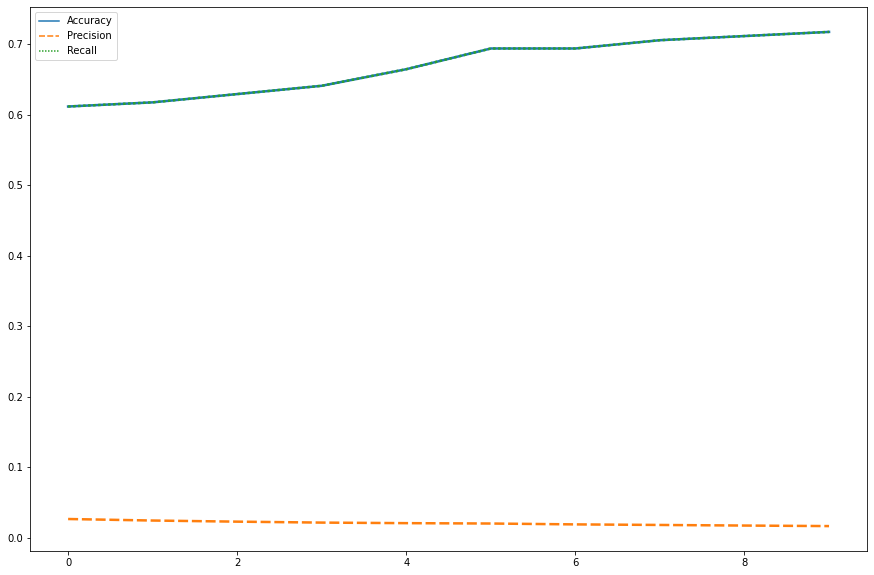

In [56]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df_metrics, palette="tab10", linewidth=2.5)

In [57]:
pr

[0.026262626262626262,
 0.024104683195592287,
 0.02251683501683502,
 0.021173271173271172,
 0.020382395382395384,
 0.019865319865319864,
 0.018623737373737372,
 0.017825311942959002,
 0.016975308641975308,
 0.01621477937267411]

0.03560830860534125